# Cahn-Hilliard 2D AB Model Simuation with grainsize analysis

In [2]:
#%matplotlib notebook
%load_ext autoreload
%autoreload 2

# import pickle
import random
from typing import Iterable, Dict
from threading import Thread
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from microtex.quantities import R
from microtex.modeling.cahn_hilliard import Cahn_Hilliard_2D_AB_Solver_Fast
from microtex.analysis import FFT_Analyser_2D, Domain_Analyser_2D

## Configuration

Set the material and simulation properties.

In [3]:
#  Material properties
T0 = 600                                # Temperature at t=0 [K]
c0 = 0.5                                # Average composition of B atom [atomic fraction]

La = 20_000. - 9 * T0                   # Atom intaraction constant [J/mol] (or La = num * T?)
ac = 3.0e-14                            # Gradient coefficient [Jm2/mol]

Da = 1.0 * np.exp(-240000.0 / R / T0)   # Diffusion coefficient of A atom [m2/s]
Db = 1.0 * np.exp(-240000.0 / R / T0)   # Diffusion coefficient of B atom [m2/s]

D = (Da, Db)

# Computational properties
ns = 600 * 10                           # Number of time-steps
nx = ny = 2 ** 8                        # Number of grid along x direction
                                        # Number of grid along y direction
dx = dy = 2.0e-9                        # Spacing of grids [m]
dt = (dx * dx / Da ) * 0.1              # Time increment [s]

# 1. Initialize concentration field with random noise.

random.seed(1877)
# seed = np.random.seed()

field = c0 + np.random.rand(nx, ny) * 0.01
samples = {}

configuration = dict(dx=dx, dy=dy, dt=dt, R=R, La=La, T=T0, ac=ac, D=D)

## Computation

1. Using the solver only.
2. Using the model with appropriate solver.

In [4]:
# 2. Solve the model for specified number of steps.

sampling_steps = np.unique(np.geomspace(1, ns, num=100, dtype="int") - 1)

for n in tqdm(range(ns)):
    field = Cahn_Hilliard_2D_AB_Solver_Fast(**configuration, domain=field)
    if n in sampling_steps:
        samples[n] = field

100%|██████████| 6000/6000 [01:57<00:00, 51.20it/s]


In [10]:
# Display selected fields as grid.
spectras, fits, E = [], [], []

fa = FFT_Analyser_2D(**configuration)
da = Domain_Analyser_2D(**configuration)

for index, field in samples.items():
    fa.analyze_domain(field)
    gs, psd = fa.power_spectrum()
    popt, _ = fa.fit_gaussian()
    fits.append(popt)
    spectras.append(psd)
    E.append(da.sum_total_diff_potential(field))

spectgram = np.array(spectras).T
fitarray = np.abs(np.array(fits))
Evol = np.array(E)

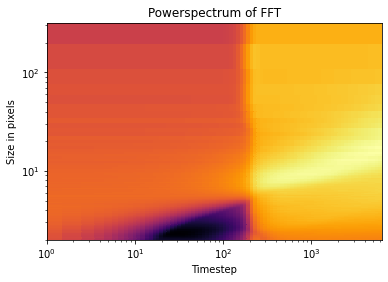

In [7]:
f, ax = plt.subplots()
xx, yy = np.meshgrid(sampling_steps, gs)
h = ax.pcolor(xx, yy, np.log(spectgram), shading='nearest', cmap='inferno')
ax.set_xlim(left=1)
ax.set_yscale('log')
ax.set_xscale('log')
# plt.colorbar(h)
plt.xlabel('Timestep')
plt.ylabel('Size in pixels')
plt.title('Powerspectrum of FFT');

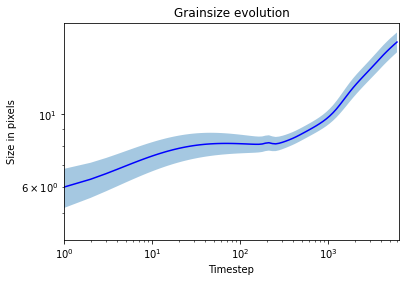

In [8]:
fig, ax = plt.subplots()
ax.plot(sampling_steps, fitarray[:,1], 'b')
ax.fill_between(sampling_steps,
                fitarray[:,1] - fitarray[:,2],
                fitarray[:,1] + fitarray[:,2], alpha=0.4)
ax.set_xlim(left=1)
ax.set_xscale('log')
ax.set_yscale('log')
plt.xlabel('Timestep')
plt.ylabel('Size in pixels')
plt.title('Grainsize evolution');

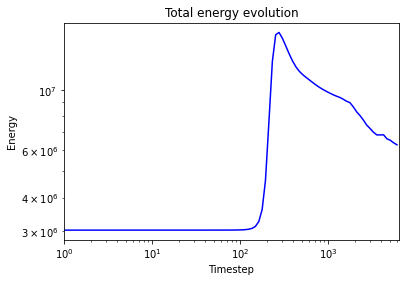

In [9]:
fig, ax = plt.subplots()
ax.plot(sampling_steps, -Evol, 'b')
ax.set_xlim(left=1)
ax.set_xscale('log')
ax.set_yscale('log')
plt.xlabel('Timestep')
plt.ylabel('Energy')
plt.title('Total energy evolution');